In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# clustering functions
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# SARIMA model and autocorrelation plots
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model throws lots of MLE convergence errors
import warnings
warnings.filterwarnings("ignore")

### Initialization

The following cells load and prep the data. To simplify the analysis, only 2015 data is included.

In [3]:
# read meta and elec data from csv into new dataframes, then fix datetimes
meta = pd.read_csv('bdgp_meta.csv',index_col=0)
meta['datastart'] = pd.to_datetime(meta['datastart'],format='%d/%m/%y %H:00')
meta['dataend'] = pd.to_datetime(meta['dataend'],format='%d/%m/%y %H:00')

raw_elec = pd.read_csv('bdgp_elec.csv',index_col=0)
raw_elec.index = pd.to_datetime(raw_elec.index,format='%Y-%m-%d %H:00:00+00:00')
del raw_elec.index.name

In [3]:
# change names of some meta values for simplicity
meta = meta.rename({'primaryspaceusage':'usage'},axis=1)
meta['usage'] = meta['usage'].map({'Office':'Office',
                                   'Dormitory':'Dormitory',
                                   'College Laboratory':'Laboratory',
                                   'College Classroom':'Classroom'
                                  })

# 0 is arizona state, 1 is europe, 2 is cornell (very good data), 3 is michigan, 4 is princeton, 5 is europe
arizona_meta = meta[meta['newweatherfilename'] == 'weather0.csv']
cornell_meta = meta[meta['newweatherfilename'] == 'weather2.csv']
michigan_meta = meta[meta['newweatherfilename'] == 'weather3.csv']
princeon_meta = meta[meta['newweatherfilename'] == 'weather4.csv']

In [4]:
# initialize the elec demand dataframe, moving 5 hours from 2016 to beginning of 2015 for simplicity
elec = raw_elec[list(cornell_meta.index)].loc['2015-01-01 0:00:00':'2015-12-31 23:00:00']
elec.iloc[0:5]=raw_elec[list(cornell_meta.index)].loc['2016-01-01 00:00:00':'2016-01-01 04:00:00'].values
elec_all = elec

elec.head(2)

,Office_Caleb,Office_Cameron,Office_Carissa,Office_Carolina,Office_Catherine,Office_Cecelia,Office_Charles,Office_Clarissa,Office_Clifton,Office_Clinton,...,UnivLab_Christine,UnivLab_Christy,UnivLab_Ciel,UnivLab_Cindy,UnivLab_Clint,UnivLab_Clodagh,UnivLab_Collin,UnivLab_Cory,UnivLab_Cristian,UnivLab_Crystal
2015-01-01 00:00:00,35.750,433.950012,86.574997,30.424999,104.575005,8.175,149.399994,7.975,15.475,93.849998,...,183.574997,47.700001,256.224991,67.974998,7.225,37.900002,165.550003,460.125000,740.975021,50.50
2015-01-01 01:00:00,35.625,405.175003,86.550003,30.775002,105.400002,8.025,149.475006,7.975,15.425,101.050003,...,180.324997,45.349998,252.824997,64.875000,7.275,37.924999,161.225006,449.700012,741.274979,49.25


### Clustering

The follow cells implement scipy's hierarchical clustering algorithm on the average hour-of-day and average day-of-week for each building.

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

In [5]:
# calculate the average day-of-week and hour-of-day profiles, then apply sklearn minmaxscaler
scaler = MinMaxScaler()

hour_of_day = elec.groupby(elec.index.hour).sum()
day_of_week = elec.groupby(elec.index.dayofweek).sum()
hour_of_day_norm = pd.DataFrame(scaler.fit_transform(hour_of_day.values),columns=hour_of_day.columns)
day_of_week_norm = pd.DataFrame(scaler.fit_transform(day_of_week.values),columns=day_of_week.columns)

0.8696719161615697

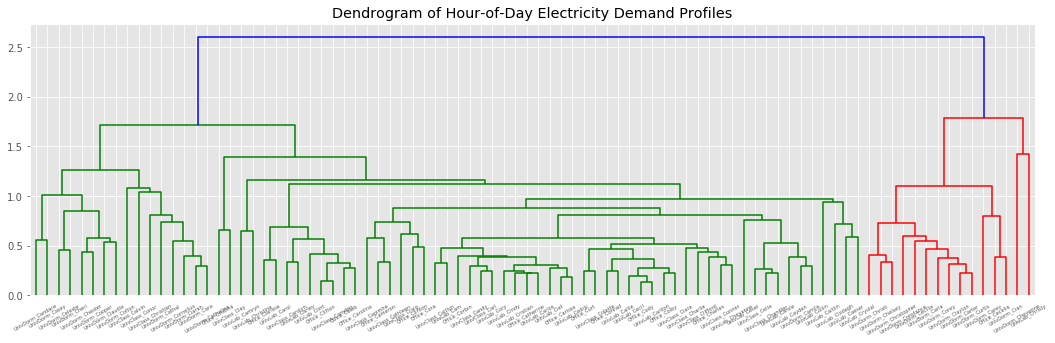

In [6]:
# create the hour-of-day linkage matrix hod_linkage
hod_linkage = linkage(hour_of_day_norm.values.T,'average')
labels = hour_of_day_norm.columns

# plot the dendrogram
plt.figure(figsize=(18, 5))
dendrogram(hod_linkage,orientation='top',labels=labels,distance_sort='descending',)
plt.xticks(rotation=30)
plt.title('Dendrogram of Hour-of-Day Electricity Demand Profiles')

# calculate the cophenetic correlation coefficient, a clustering evaluation metric (>0.75 is good)
clustering_score, coph_dists = cophenet(hod_linkage, pdist(hour_of_day_norm.values.T))
clustering_score

0.6089287760747909

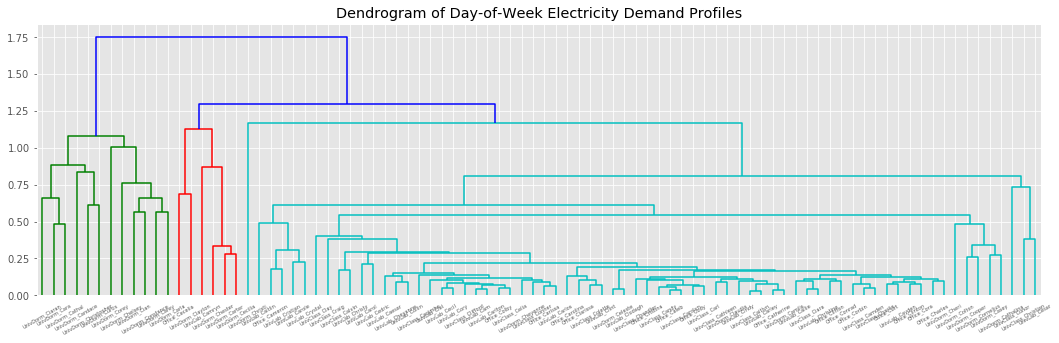

In [7]:
# repeat the process for the average day-of-week data
dow_linkage = linkage(day_of_week_norm.values.T,'average')
labels = day_of_week_norm.columns

plt.figure(figsize=(18,5))
dendrogram(dow_linkage,orientation='top',labels=labels,distance_sort='descending')
plt.xticks(rotation=30)
plt.title('Dendrogram of Day-of-Week Electricity Demand Profiles')

clustering_score, coph_dists = cophenet(dow_linkage, pdist(hour_of_day_norm.values.T))
clustering_score

The dendrograms support two and three clusters based on hour-of-day and day-of-week profiles, respectively. The next cell defines these clusters and plots the results.

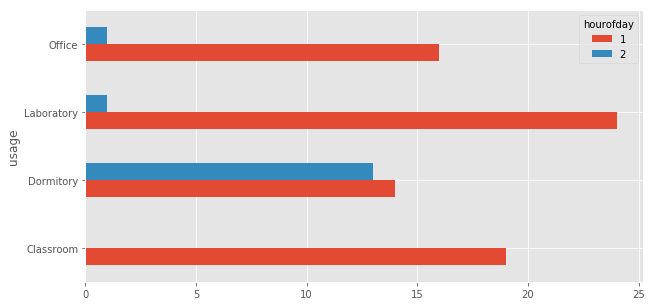

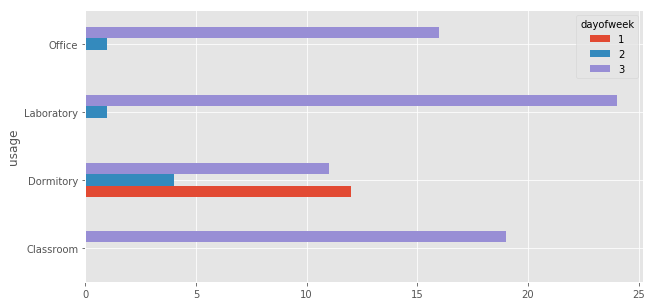

In [8]:
# create clusters based on dendrograms, middle argument gives number of clusters
hod_clustering = fcluster(hod_linkage,2,criterion='maxclust')
dow_clustering = fcluster(dow_linkage,3,criterion='maxclust')

# populate a clusters dataframe based on the results of the clustering analysis
clusters = pd.DataFrame(cornell_meta['usage'],index=list(cornell_meta.index))
clusters['hourofday'], clusters['dayofweek'] = hod_clustering, dow_clustering

# plot the breakdown of each usage into clusters
hod_matrix = pd.crosstab(clusters['usage'],clusters['hourofday'])
dow_matrix = pd.crosstab(clusters['usage'],clusters['dayofweek'])
hod_matrix.plot(kind='barh',figsize=(10,5))
dow_matrix.plot(kind='barh',figsize=(10,5))

Moving on, the two hour-of-day clusters will be used. Clustering based on hour-of-day is probably more effective than day of week, because the day of week effects can be controlled more effectively using transformers. However, this assumption will be tested moving forward.

In [9]:
# define clusters 1 and 2 based on hour of day clusters from above
cluster1_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 1]
cluster2_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 2]

cluster1 = pd.Series(elec[cluster1_buildings].sum(axis=1))
cluster2 = pd.Series(elec[cluster2_buildings].sum(axis=1))
aggregate = pd.Series(elec.sum(axis=1))
actual = pd.Series(elec.sum(axis=1))

### Transformation of median-shifting features

Many predictive models require stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) effects as well as trend (steady/exponential increase) effects.

The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

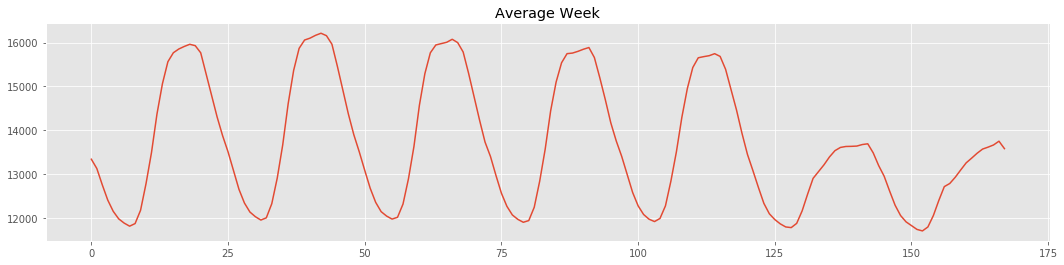

In [10]:
# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(72,168) # 2015 starts on a thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:8760]

# create a stationary version of each cluster. yes, variables are being rewritten frequently.
avg_week = cluster1.groupby(hourofweek).mean()
cluster1_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = cluster1.groupby(cluster1.index.weekofyear).mean()
cluster1_year_transformer = cluster1.index.weekofyear.map(avg_year)
cluster1_stationary = cluster1/cluster1_week_transformer/cluster1_year_transformer

avg_week = cluster2.groupby(hourofweek).mean()
cluster2_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = cluster2.groupby(cluster2.index.weekofyear).mean()
cluster2_year_transformer = cluster2.index.weekofyear.map(avg_year)
cluster2_stationary = cluster2/cluster2_week_transformer/cluster2_year_transformer

avg_week = aggregate.groupby(hourofweek).mean()
aggregate_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = aggregate.groupby(aggregate.index.weekofyear).mean()
aggregate_year_transformer = aggregate.index.weekofyear.map(avg_year)
aggregate_stationary = aggregate/aggregate_week_transformer/aggregate_year_transformer

# plot an average week for diagnostics
avg_week.plot(figsize=(18,4),title="Average Week")

As you can see in the "stationary" plot below, the transformations used do not accurately remove the effects of holidays shorter than one week, like the 4th of July, Thanksgiving, Christmas. To improve the model, these could be hard-coded or identified by clustering with weekends over multiple years of data.

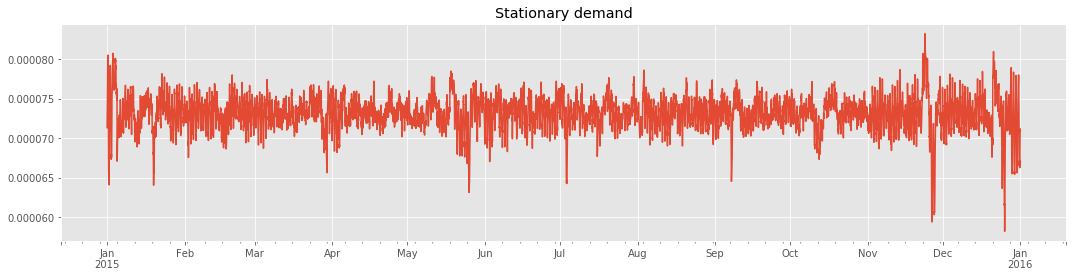

In [11]:
aggregate_stationary.plot(figsize=(18,4),title='Stationary demand')

### Predictive Modeling: Seasonal ARIMA

The SARIMA (seasonal autoregressive integrated moving average) model has four parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24. SARIMA also supports trend terms, but there is no trend in this data, so they will not be used.

The cells below train and test SARIMA models for several days in of the training set, starting on February 1st. The MAPE of each daily forecast is stored in the mapes DataFrame, and the predictions are stored in the y_forecast Series.

In [12]:
# dataframe containing data to be tested
data = pd.DataFrame({'cluster1':cluster1_stationary,
                     'cluster2':cluster2_stationary,
                     'aggregate':aggregate_stationary})

# model parameters
num_days = 300
start = '2015-02-01 09:00:00'
trend_params = (0,0,0)
seasonal_params = (1,0,1,24)

In [13]:
# initialize some useful objects for the modeling loop
start_times = pd.date_range(start=start,freq='D',periods=num_days)
forecasts = data.copy(deep=True)

for k in data.columns:
    for i in range(num_days):
        y_train = data[k].loc[data.index < start_times[i]].values
        # train and fit the model
        model = SARIMAX(y_train, order=trend_params,seasonal_order=seasonal_params,enforce_stationarity=False)
        model_fit = model.fit(disp=0,maxiter=200)
        # make and store a 39-step-forward forecast
        forecast = model_fit.forecast(steps=39)[15:]
        forecasts[k].loc[start_times[i]+pd.Timedelta(hours=15):start_times[i]+pd.Timedelta(hours=38)]=forecast

The next cell creates a results dataframe with forecasts for the individual cluster forecasts and the aggregate forecast. It also includes the actual data for easy comparison, then plots the results.

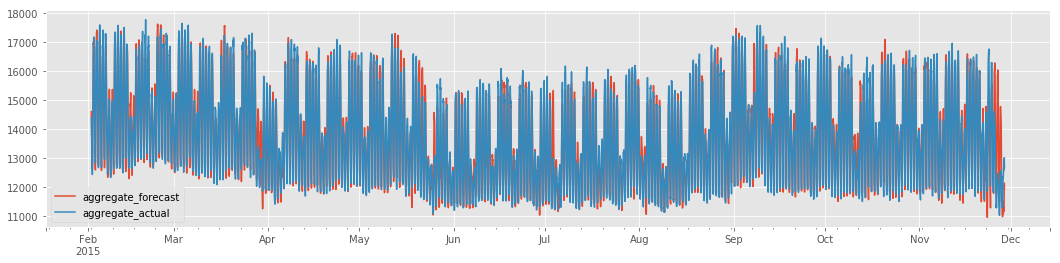

In [14]:
results = pd.DataFrame(index = forecasts.index)

# reverse the transformations, add actual columns
results['cluster1_forecast'] = forecasts['cluster1']*cluster1_year_transformer*cluster1_week_transformer
results['cluster2_forecast'] = forecasts['cluster2']*cluster2_year_transformer*cluster2_week_transformer
results['cluster_sum_forecast'] = results['cluster1_forecast'] + results['cluster2_forecast']
results['aggregate_forecast'] = forecasts['aggregate']*aggregate_year_transformer*aggregate_week_transformer
results['cluster1_actual'], results['cluster2_actual'] = cluster1.values, cluster2.values
results['aggregate_actual'] = actual.values

results = results[start_times[0]+pd.Timedelta(hours=15):start_times[num_days-1]+pd.Timedelta(hours=38)]

results[['aggregate_forecast','aggregate_actual']].plot(figsize=(18,4))

In [15]:
# define helper mape function, print the mape of individual clusters, the cluster sum, and agg forecasts
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

print('Average MAPE for {} day-ahead forecasts:\n'.format(num_days))
print('Cluster 1:     {}'.format(np.round(mape(results.cluster1_actual,results.cluster1_forecast),3)))
print('Cluster 2:     {}'.format(np.round(mape(results.cluster2_actual,results.cluster2_forecast),3)))
print('Cluster Sum:   {}'.format(np.round(mape(results.aggregate_actual,results.cluster_sum_forecast),3)))
print('Aggregate:     {}'.format(np.round(mape(results.aggregate_actual,results.aggregate_forecast),3)))

Average MAPE for 300 day-ahead forecasts:

Cluster 1:     1.934
Cluster 2:     4.518
Cluster Sum:   1.941
Aggregate:     1.95


### More visualizations of the results???